# Stratify Discrete Score by Severity

In [1]:
import pyspark.sql.functions as f

import matplotlib.pyplot as plt
%matplotlib inline

### Loading the data

In [2]:
ROOT_PATH="gs://green-1-accelerators-1-username-dpr-stg-bucket/"#path to staging bucket
FILE_PATH="scoring/Document/Customer"
SCORE_ID_OF_INTEREST="HighRiskCustomerDiscrete"
CUSTOMER_PATH="customer/DocumentDataModel/CleansedDocumentDataModel.parquet"

Load the output score and customer data.

In [3]:
df = spark.read.parquet(ROOT_PATH+FILE_PATH)

In [4]:
customers = spark.read.parquet(ROOT_PATH+CUSTOMER_PATH)

 Find the score of interest to select a stratification.

In [6]:
score_customers = df.select("id",f.col("basicScoreOutputMap")\
                 .getItem(SCORE_ID_OF_INTEREST).alias("scoreOutput"))\
                .select("id","scoreOutput.*")

Replace null severities with zero.

In [8]:
score_customers_severities = score_customers\
        .select("id", "severity", "description")\
        .withColumn("severity", f.when(f.col("severity").isNull(),f.lit(0))\
                    .otherwise(f.col("severity")))

### Review data

Look at the distribution of data and plot histogram.

In [9]:
score_customers_severities_pd = score_customers_severities.toPandas()

In [10]:
score_customers_severities_pd.head(10)

,id,severity,description
0,1937937421,0,None
1,5085464662,0,None
2,6029246402,0,None
3,10092942152,20,High risk customer Harry Krichauff (10092942152).
4,10910136667,80,High risk customer Matthew Tremper (10910136667).
5,14790341630,0,None
6,24986141054,0,None
7,28471596220,0,None
8,34113997963,0,None
9,35067368037,0,None


In [62]:
severity_counts = score_customers_severities_pd.severity.value_counts().sort_index()
severity_counts_pd=severity_counts.to_frame()

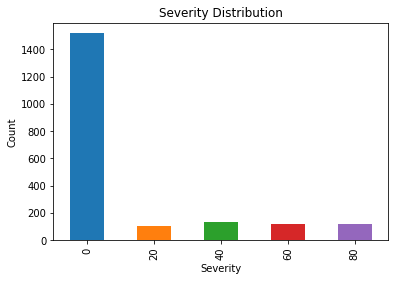

In [12]:
severity_counts.plot(kind='bar')
plt.title("Severity Distribution")
plt.xlabel("Severity")
plt.ylabel("Count")
plt.show()

### Sample data

Choose fractions of each severity to sample. The severities can all be the same eg. <br>
`
fractions = score_customers_severities.select("severity").distinct()\
            .withColumn("fraction", lit(0.02))\
            .rdd.collectAsMap()`   
or can create a custom dictionary (see below).

In [ ]:
def create_fractions_for_sample(severity_counts_df, sample_sizes):
    """
    function to create custom dictionary of fractions for severity samples.
    severity_counts_df: pandas dataframe containing severities and total counts
    sample_sizes: ordered list of the required sample size for each severity. 
    (The sampling is probabilistic and therefore the required sample sizes are 
    an approximation of the number of samples you will receive. It is therefore 
    advised to use 2 as the minimum sample size to ensure that a sample is obtained.)
    """
    severity_counts_df['sample_count'] = sample_sizes
    fractions_dict = {}
    for index, row in severity_counts_df.iterrows():
        fractions_dict[int(row[0])] = row[2]/row[1]
        
    return fractions_dict

In [63]:
severity_counts_pd.reset_index(level=0, inplace=True)
severity_counts_pd.rename(index=str, columns={"index": "severity", "severity": "total_count"})

,severity,total_count
0,0,1519
1,20,106
2,40,136
3,60,118
4,80,121


In [64]:
fractions=create_fractions_for_sample(severity_counts_pd, [2,2,3,3,4])

In [65]:
sampled_df = score_customers_severities.stat.sampleBy("severity", fractions, seed=123)

In [67]:
score_customers_severities_count=score_customers_severities.groupBy("severity").count()\
    .orderBy("severity").select(f.col("severity"), f.col("count").alias("total_count"))

In [69]:
sampled_df_count=sampled_df.groupBy("severity").count().select(f.col("severity"), f.col("count").alias("sample_count"))

In [70]:
score_customers_severities_count.join(sampled_df_count,"severity").orderBy("severity").show()

+--------+-----------+------------+
|severity|total_count|sample_count|
+--------+-----------+------------+
|       0|       1519|           1|
|      20|        106|           2|
|      40|        136|           4|
|      60|        118|           2|
|      80|        121|           7|
+--------+-----------+------------+



### Join sampled data with customers

Join customer data to the sampled score data. Select the key features to show to client.

In [33]:
sampled_df_customers = sampled_df\
            .join(customers, sampled_df.id == customers.customerIdNumberString)

In [34]:
sampled_df_output = sampled_df_customers\
    .select("customerIdNumber", "forename", "familyName", "severity", "description")

In [35]:
sampled_df_output.limit(20).toPandas().head(20)

,customerIdNumber,forename,familyName,severity,description
0,44062026113,Lukas,Schultz,40,High risk customer Lukas Schultz (44062026113).
1,77640044198,Malcolm,Alston,20,High risk customer Malcolm Alston (77640044198).
2,59136631098,Desire,Deslauriers,40,High risk customer Desire Deslaurie (591366310...
3,99798232913,M,Williams,80,High risk customer Mamie Williams (99798232913).
4,58891927697,None,None,0,None
5,78420972928,Stefan,Kohl,40,High risk customer Stefan Kohl (78420972928).
6,75440916009,Charles,Flores,80,High risk customer Charles Flores (75440916009).
7,27352445533,Armentar,Soria,60,High risk customer Armentar Soria (27352445533).
8,2174571809,Dylan,Foster,80,High risk customer Dylan Foster (2174571809).
9,92111645764,Duilio,Longo,60,High risk customer Duilio Longo (92111645764).


Save output

In [36]:
sampled_df_output.repartition(1).write.csv(path=ROOT_PATH+SCORE_ID_OF_INTEREST+"_samples.csv", mode="overwrite", header="true")

In [37]:
#if running locally
#sampled_df_output_pd = sampled_df_output.toPandas()
#sampled_pd.to_csv(ROOT_PATH+"sample_file.csv", header=True, index=False)
#sampled_pd.to_excel(ROOT_PATH+"sample_file.xlsx", header=True, index=False)